# Comparison reading GOES data from AWS S3 in netCDF versus zarr

In [1]:
#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
import os.path
import matplotlib.pyplot as plt

# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


## Define a function to read the netCDF data 
- The last 30 days are on S3 standard access, after that it is move to infrequent access
- It takes about 3 minutes to connect to a days worth of data for a single product

In [2]:
def get_geo_data(sat,lyr,idyjl):
    # arguments
    # sat   goes-east,goes-west,himawari
    # lyr   year
    # idyjl day of year
    
    d = dt.datetime(lyr,1,1) + dt.timedelta(days=idyjl)
    fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

    #create strings for the year and julian day
    imon,idym=d.month,d.day
    syr,sjdy,smon,sdym = str(lyr).zfill(4),str(idyjl).zfill(3),str(imon).zfill(2),str(idym).zfill(2)
    
    #use glob to list all the files in the directory
    if sat=='goes-east':
        file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='goes-west':
        file_location,var = fs.glob('s3://noaa-goes17/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='himawari':
        file_location,var = fs.glob('s3://noaa-himawari8/AHI-L2-FLDK-SST/'+syr+'/'+smon+'/'+sdym+'/*/*L2P*.nc'),'sea_surface_temperature'
    
    #make a list of links to the file keys
    if len(file_location)<1:
        return file_ob
    file_ob = [fs.open(file) for file in file_location]        #open connection to files
    
    #open all the day's data
    ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time') #note file is super messed up formatting
    
    #clean up coordinates which are a MESS in GOES
    #rename one of the coordinates that doesn't match a dim & should
    if not sat=='himawari':
        ds = ds.rename({'t':'time'})
        ds = ds.reset_coords()
    else:
        ds = ds.rename({'ni':'x','nj':'y'}) #for himawari change dims to match goes 
    
    #put in to Celsius
    #ds[var] -= 273.15   #nice python shortcut to +- from itself a-=273.15 is the same as a=a-273.15
    #ds[var].attrs['units'] = '$^\circ$C'
   
    return ds


## Open a day of GOES-16  (East Coast) Data and plot the average SST - netCDF

In [3]:
%%time

lyr, idyjl = 2020, 210

ds = get_geo_data('goes-east',lyr,idyjl)

CPU times: user 15.2 s, sys: 2.31 s, total: 17.5 s
Wall time: 2min 45s


CPU times: user 1min 46s, sys: 34.1 s, total: 2min 20s
Wall time: 19min 19s


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


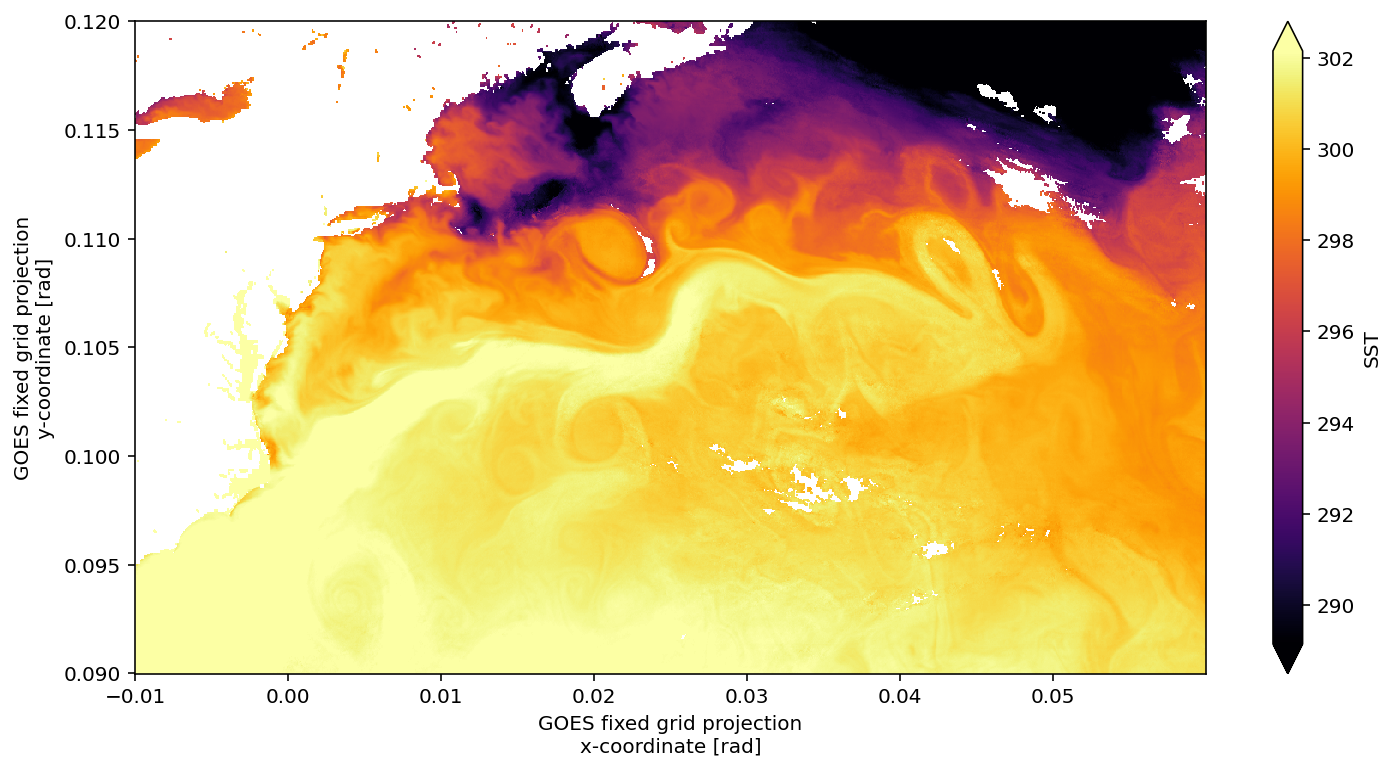

In [4]:
%%time
subset = ds.sel(x=slice(-0.01,0.06),y=slice(0.12,0.09))  #reduce to GS region
masked = subset.SST.where(subset.DQF==0)
mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True
mean_dy.plot(vmin=16+273.15,vmax=29+273.15,cmap='inferno')

# Exact same process, but with Zarr file stored on S3 us-east-1, just like the netcdf files above

In [5]:
%%time

file_location = 's3://ohw-bucket-us-east-1/goes_zarr'

ikey = fsspec.get_mapper(file_location,anon=False)

ds = xr.open_zarr(ikey) 

ds

CPU times: user 967 ms, sys: 0 ns, total: 967 ms
Wall time: 24.1 s


<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, time: 24, x: 5424, y: 5424)
Coordinates:
  * time                                                    (time) datetime64[ns] ...
  * x                                                       (x) float32 -0.15...
  * y                                                       (y) float32 0.151...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    DQF                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    algorithm_dynamic_input_data_container                  (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    algorithm_product_version_container                     (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    day_solar_zenith_angle                                  float32 ...
    day_solar_zenith_angle_bounds                           (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    geospatial_lat_lon_extent                               (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    goes_imager_projection                                  (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    max_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    max_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    maximum_sea_surface_temp                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_obs_modeled_diff_SST_night_only_emissive_band      (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_retrieved_Reynolds_SST_diff                        (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_sea_surface_temp                                   (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    min_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    min_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    minimum_sea_surface_temp                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    night_solar_zenith_angle                                float32 ...
    night_solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_height                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    nominal_satellite_subpoint_lat                          (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    nominal_satellite_subpoint_lon                          (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    number_of_day_SST_pixels                                (time) float64 dask.arra

CPU times: user 3.03 s, sys: 1.8 s, total: 4.83 s
Wall time: 9.13 s


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


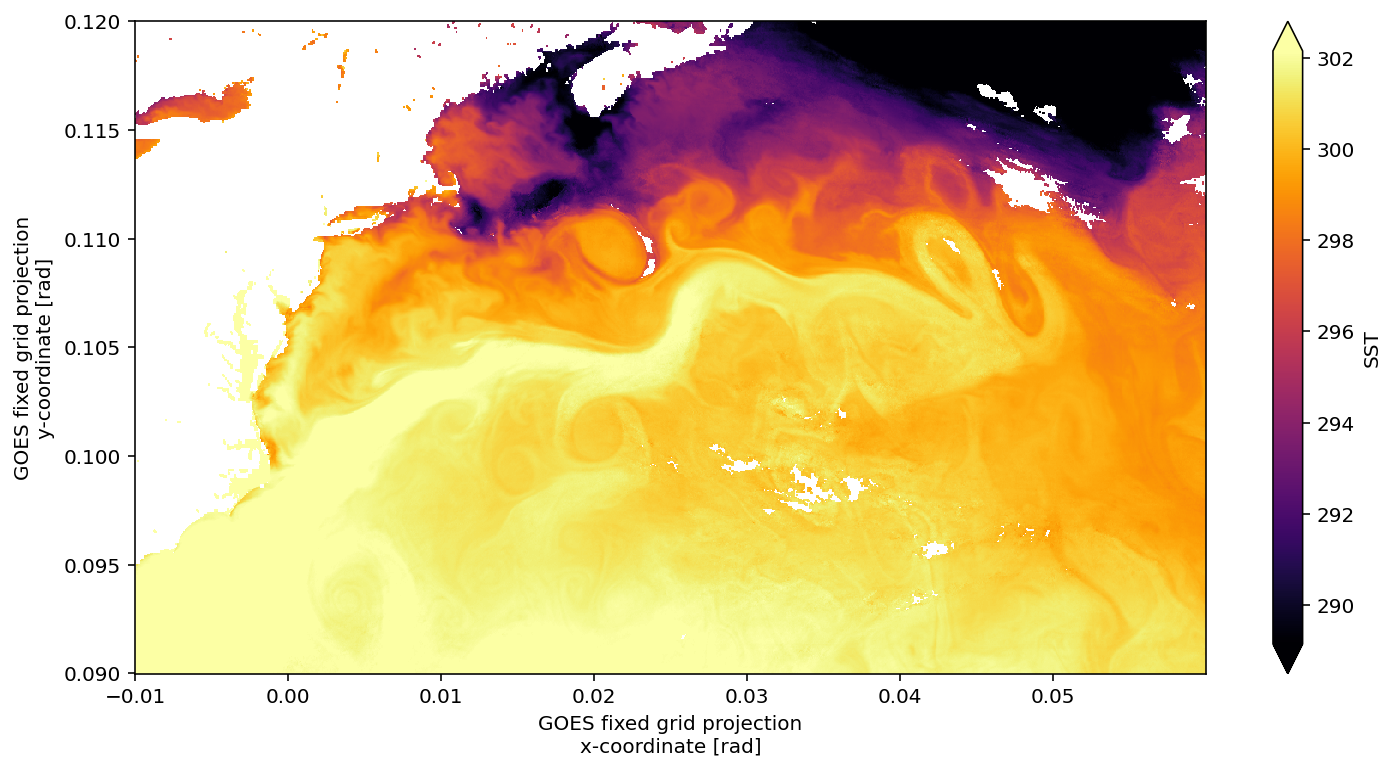

In [6]:
%%time
subset = ds.sel(x=slice(-0.01,0.06),y=slice(0.12,0.09))  #reduce to GS region
masked = subset.SST.where(subset.DQF==0)
mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True
mean_dy.plot(vmin=16+273.15,vmax=29+273.15,cmap='inferno')

# Again, but with Zarr file stored on S3 in same region as this jupyter hub

In [7]:
%%time

file_location = 's3://ohw-bucket/goes_zarr'

ikey = fsspec.get_mapper(file_location,anon=False)

ds = xr.open_zarr(ikey) #,consolidated=True)

ds

CPU times: user 791 ms, sys: 0 ns, total: 791 ms
Wall time: 5.05 s


<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, time: 24, x: 5424, y: 5424)
Coordinates:
  * time                                                    (time) datetime64[ns] ...
  * x                                                       (x) float32 -0.15...
  * y                                                       (y) float32 0.151...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    DQF                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    algorithm_dynamic_input_data_container                  (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    algorithm_product_version_container                     (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    day_solar_zenith_angle                                  float32 ...
    day_solar_zenith_angle_bounds                           (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    geospatial_lat_lon_extent                               (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    goes_imager_projection                                  (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    max_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    max_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    maximum_sea_surface_temp                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_obs_modeled_diff_SST_night_only_emissive_band      (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_retrieved_Reynolds_SST_diff                        (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_sea_surface_temp                                   (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    min_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    min_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    minimum_sea_surface_temp                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    night_solar_zenith_angle                                float32 ...
    night_solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_height                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    nominal_satellite_subpoint_lat                          (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    nominal_satellite_subpoint_lon                          (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    number_of_day_SST_pixels                                (time) float64 dask.arra

CPU times: user 3.17 s, sys: 2.19 s, total: 5.36 s
Wall time: 6.59 s


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


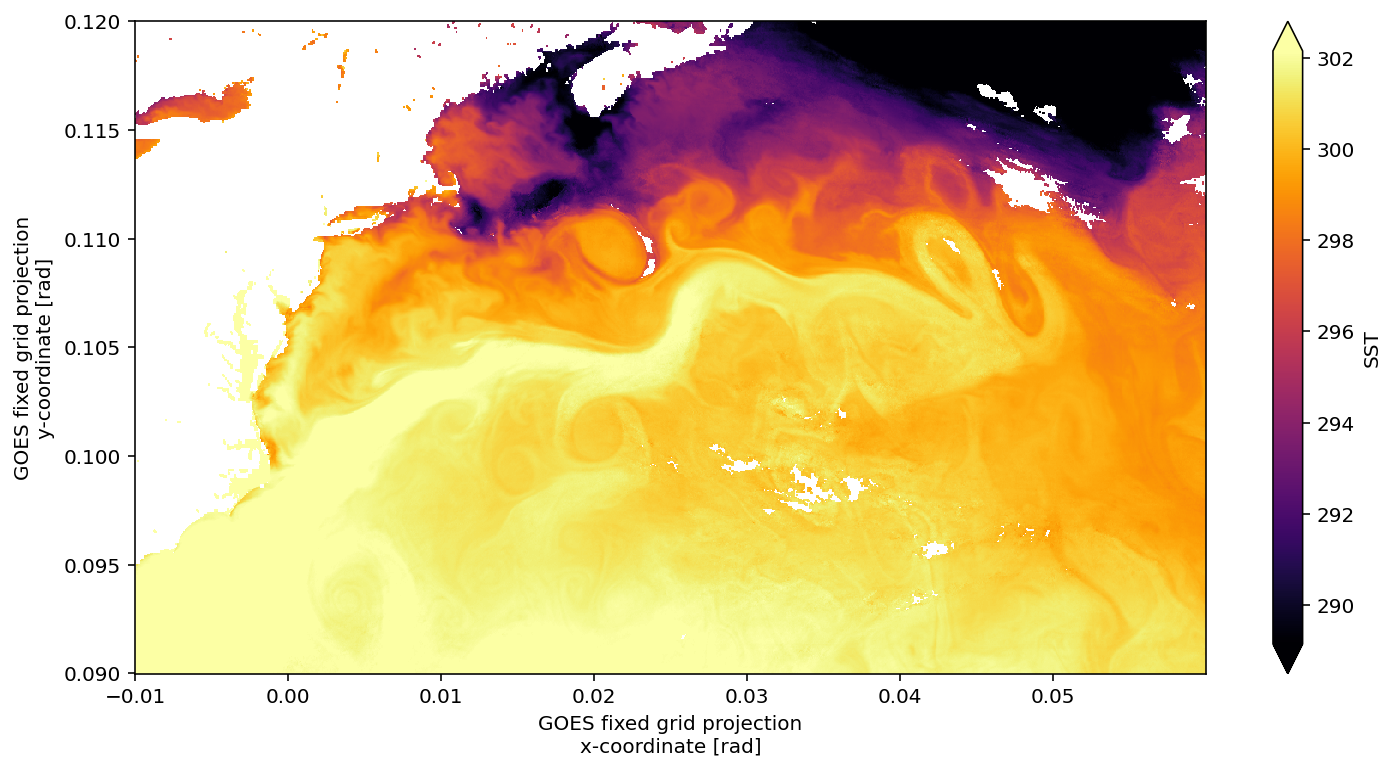

In [8]:
%%time
subset = ds.sel(x=slice(-0.01,0.06),y=slice(0.12,0.09))  #reduce to GS region
masked = subset.SST.where(subset.DQF==0)
mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True
mean_dy.plot(vmin=16+273.15,vmax=29+273.15,cmap='inferno')

## Summarize Results reading GOES data on the cloud

- Code run from Jupyter Hub on us-west-2
- Compare results reading netcdf and zarr files both stored on us-east-1
- Compare results reading zarr stored next to hub, both on us-west-2


| Format | Region | Access-time (sec) | Analysis-time (sec) | Total effort (%) |
| :---   | :---   |    :----:   |        :----:| :----: |
| NetCDF      | different       | 165   | 1159 | 100 |
| Zarr      | different       | 24   | 9 | 2.5 |
| Zarr      | same       | 5   | 7 | 0.1 |
